# Bayes rule and internal consistency

Bayesianist interpret probabilities as subjective opinions that depend on the background knowledge. As such the question whether statistical inference produces results that are consistent with other theories is ill-posed -- if a person does not belive base results of a theory his or her posterior does not have match the predictions of the theory.

However, the inference must still adhere internal consistence. That is, we should always get the same results, if we rephrase the problem in different but equivalent ways. Next examples about coinflipping show that the Bayes theorem satisfies restriction. 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import numpy.random as rnd

from pandas import Series
from pandas import DataFrame
from typing import List

from tqdm import tnrange
from plotnine import *

# Homework

## 7.1  Belief update for a single and multiple observations (<font color='red'>1p</font>)

Let us consider a coin with bias $\alpha$, i.e., $\Pr[B_i =1|\alpha]=\alpha$ and $\Pr[B_i = 0|\alpha]=1-\alpha$.
Describe how the initial beliefs must change if we observe single coinflip $B_1$ or several coinflips $B_1,\ldots,B_n$. Define two belief unpdate functions `update_beliefs_1` and `update_beliefs_2` that implement these rules.    

## Solution

In [2]:
def update_beliefs_1(prior: DataFrame, b: int) -> DataFrame:
    return prior.assign(likelihood = lambda df: df['alpha']**b * (1 - df['alpha'])**(1 - b),
                        posterior = lambda df: df['likelihood'] * df['pr'],
                        pr = lambda df: df['posterior'] / df['posterior'].sum())[['alpha', 'pr']]

def update_beliefs_2(prior: DataFrame, B: List[int]) -> DataFrame:
    k = sum(B)
    n = len(B)
    
    return prior.assign(likelihood = lambda df: df['alpha']**k * (1 - df['alpha'])**(n - k),
                        posterior = lambda df: df['likelihood'] * df['pr'],
                        pr = lambda df: df['posterior'] / df['posterior'].sum())[['alpha', 'pr']]

## 7.2 Internal consistency of belief update rules (<font color='red'>1p</font>)

Given a set of observations $B_1,\ldots,B_n$, we can update our beliefs by observing single $B_i$ at a time or update our beliefs by considering all observations at once. The first corresponds to iterative application of `update_beliefs_1` and the second a single update with `update_beliefs_2`. Show eperimentally that both strategies give the same result by testing this on 10 different observation vectors of length 15 and on two different prior assignments over the grid $\{0.0, 0.1,\ldots, 1.0\}$.

## Solution

**We defined two priors: a uniform prior where each alpha is equally likely, and a sceptical prior that thinks $\alpha \in \{ 0, 1 \}$ is much more likely than $\alpha \in \{ 0.1, 0.2, ..., 0.9\}$.**

In [3]:
uniform_prior = DataFrame({'alpha': np.linspace(0, 1, num = 11, endpoint = True), 'pr': 1/11})
display(uniform_prior)

,alpha,pr
0,0.0,0.090909
1,0.1,0.090909
2,0.2,0.090909
3,0.3,0.090909
4,0.4,0.090909
5,0.5,0.090909
6,0.6,0.090909
7,0.7,0.090909
8,0.8,0.090909
9,0.9,0.090909


In [4]:
sceptical_prior = DataFrame({'alpha': np.linspace(0, 1, num = 11, endpoint = True)}) \
    .assign(pr = lambda df: np.where(df['alpha'].isin([0, 1]), 0.455, 0.01))
display(sceptical_prior)

,alpha,pr
0,0.0,0.455
1,0.1,0.010
2,0.2,0.010
3,0.3,0.010
4,0.4,0.010
5,0.5,0.010
6,0.6,0.010
7,0.7,0.010
8,0.8,0.010
9,0.9,0.010


**We generated 15 observations -- coin throws with probability 0.5 -- 10 times and visually verified that there was no difference between the batch update and the iterative update.**

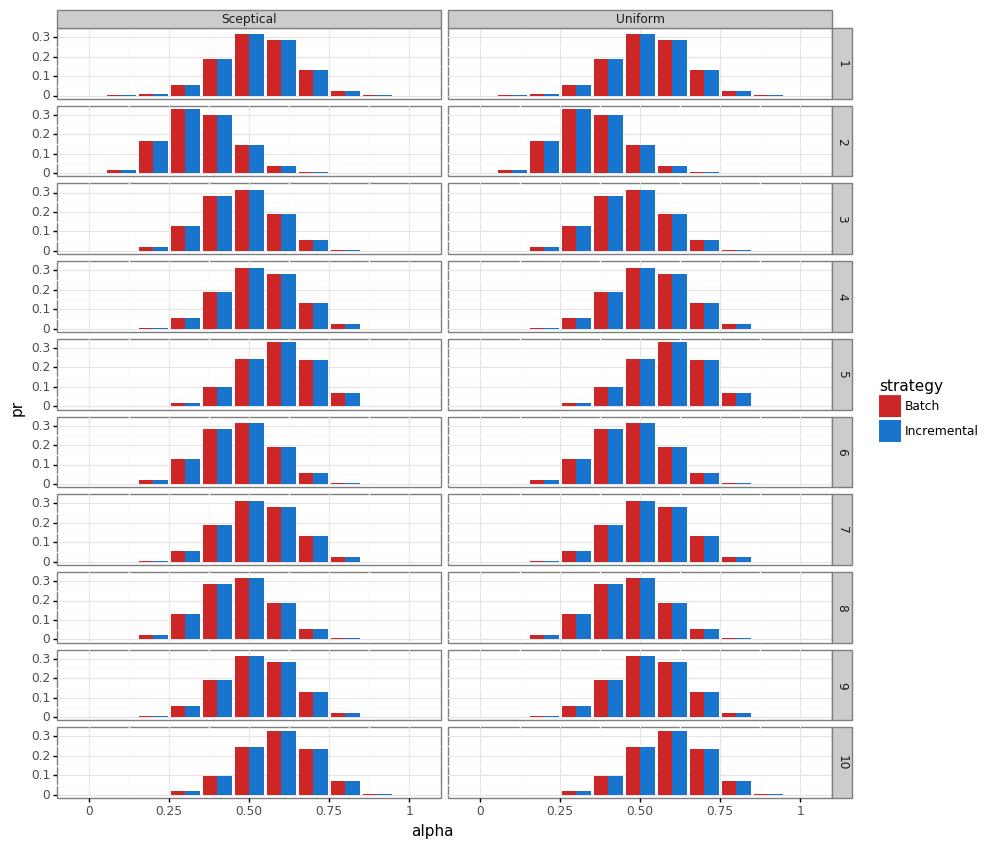

<ggplot: (-9223372029299469259)>

In [5]:
def iterative_update_beliefs_1(prior: DataFrame, B: List[int]) -> DataFrame:
    for b in B:
        prior = update_beliefs_1(prior, b)
    final_posterior = prior
        
    return final_posterior

posteriors = []
for i in range(10):
    observations = np.random.randint(0, 2, 15)
    
    posteriors.append(iterative_update_beliefs_1(uniform_prior, observations).assign(run = i + 1, prior = 'Uniform', strategy = 'Incremental'))
    posteriors.append(iterative_update_beliefs_1(sceptical_prior, observations).assign(run = i + 1, prior = 'Sceptical', strategy = 'Incremental'))
    posteriors.append(update_beliefs_2(uniform_prior, observations).assign(run = i + 1, prior = 'Uniform', strategy = 'Batch'))
    posteriors.append(update_beliefs_2(sceptical_prior, observations).assign(run = i + 1, prior = 'Sceptical', strategy = 'Batch'))
posteriors = pd.concat(posteriors, ignore_index = True)

ggplot(posteriors, aes(x = 'alpha', y = 'pr', fill = 'strategy')) + \
    geom_col(position = 'dodge') + \
    facet_grid(['run', 'prior']) + \
    scale_fill_manual(values = ['#CD2626', '#1874CD']) + \
    theme_bw() + \
    theme(figure_size = (10, 10))

## 7.3 External consistency for infinite observers (<font color='red'>1p</font>)
Although orthodox Bayesianism excludes the question of correctness, we can still experiment whether our posterior distribution converges to true value given enough observations. Let the true value of $\alpha$ be $0.5$. Consider a uniform prior and sceptical prior $\Pr[\alpha=0.0] = 0.455$, $\Pr[\alpha=1.0] = 0.455$,
$\Pr[\alpha=0.1] =\ldots=\Pr[\alpha=0.9]= 0.01$. Draw $1024$ samples and compute posterior distributions after observing $4$, $16$, $64$, $256$, $1024$ samples. Interpret results.

**Extra point:** Let the closeness of the posterior with the true answer $\alpha=0.5$ be measured as $\delta=1-\Pr[\alpha=0.5|B_1,\ldots,B_{N}]$. Visualise the random nature of convergence to the true value by plotting the $\delta$ values for $100$ experiments and draw lower $5\%$ quantiles.   

## Solution

**We simulated the coin throw $1024$ times with an unbiased coin ($\alpha = 0.5$) and computed posterior distributions for both the uniform and sceptical priors after observing $0, 1, 2, 3, 4, 16, 64, 256, 1024$ samples.**

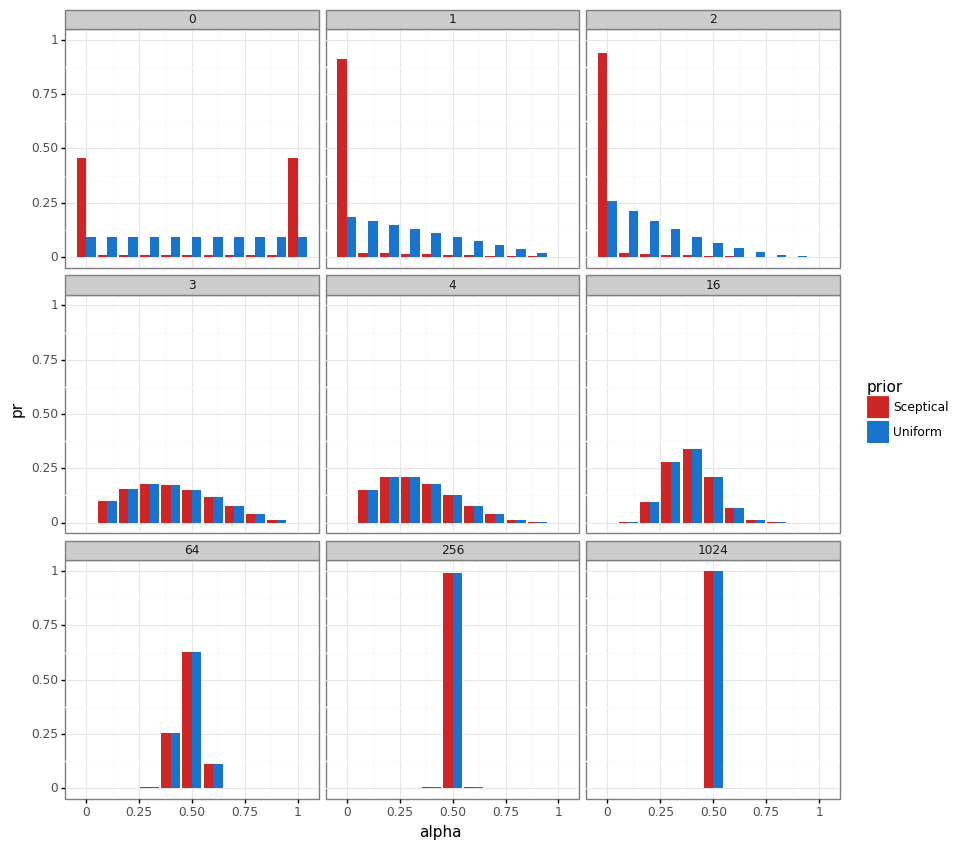

<ggplot: (-9223372029298259298)>

In [6]:
alpha_true = 0.5
N = 1024
observations = np.random.binomial(n = 1, p = alpha_true, size = N)

posteriors = []
for cutoff in [0, 1, 2, 3, 4, 16, 64, 256, N]:
    posteriors.append(update_beliefs_2(uniform_prior, observations[:cutoff]).assign(samples = cutoff, prior = 'Uniform'))
    posteriors.append(update_beliefs_2(sceptical_prior, observations[:cutoff]).assign(samples = cutoff, prior = 'Sceptical'))
posteriors = pd.concat(posteriors, ignore_index = True)

ggplot(posteriors, aes(x = 'alpha', y = 'pr', fill = 'prior')) + \
    geom_col(position = 'dodge') + \
    facet_wrap(['samples']) + \
    scale_fill_manual(values = ['#CD2626', '#1874CD']) + \
    theme_bw() + \
    theme(figure_size = (10, 10))

**We can see that the two priors give identical posteriors already after having seen at least one each of heads and tails.**

**In the following, we also visualised the convergence of the closeness $\delta$ of the posteriors with the true $\alpha = 0.5$ by repeating the above experiment 100 times and finding the $5\%$-quantile for each coin throw $i = 1, ..., 1024$.**

In [7]:
N_sims = 100
uniform_deltas = np.empty((N + 1, N_sims))
sceptical_deltas = np.empty((N + 1, N_sims))

for i in tnrange(N_sims):
    observations = np.random.binomial(n = 1, p = alpha_true, size = N)
        
    uniform_posterior = uniform_prior
    sceptical_posterior = sceptical_prior
    
    uniform_deltas[0, i] = 1 - uniform_posterior.loc[uniform_posterior.alpha == alpha_true, 'pr']
    sceptical_deltas[0, i] = 1 - sceptical_posterior.loc[sceptical_posterior.alpha == alpha_true, 'pr']
    
    for j in range(N):
        uniform_posterior = update_beliefs_1(uniform_posterior, observations[j])
        uniform_deltas[j+1, i] = 1 - uniform_posterior.loc[uniform_posterior.alpha == alpha_true, 'pr']
        
        sceptical_posterior = update_beliefs_1(sceptical_posterior, observations[j])
        sceptical_deltas[j+1, i] = 1 - sceptical_posterior.loc[sceptical_posterior.alpha == alpha_true, 'pr']

**Convergence figures for both priors:**

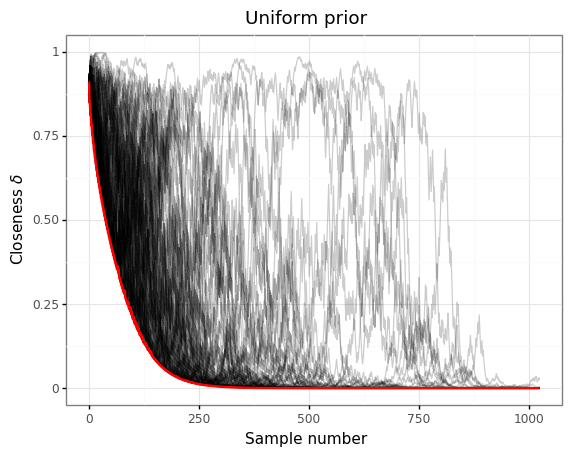

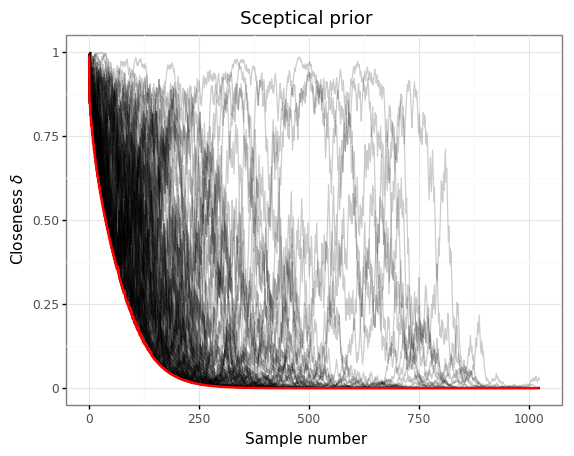

[<ggplot: (7555764274)>, <ggplot: (7555729763)>]

In [8]:
def plot_closeness(deltas_mat, title):
    deltas_dat = DataFrame(deltas_mat, columns = ['run_{}'.format(i) for i in range(deltas_mat.shape[1])]) \
        .assign(x = np.arange(0, deltas_mat.shape[0]),
                q_05 = np.apply_along_axis(np.quantile, 1, deltas_mat, q = 0.05))

    gg = ggplot(deltas_dat, aes(x = 'x')) + \
        theme_bw() + \
        ylab(r'Closeness $\delta$') + \
        xlab('Sample number') + \
        ggtitle(title)
    for i in range(deltas_mat.shape[1]):
        gg = gg + geom_line(aes(y = 'run_{}'.format(i)), alpha = 0.2)
    gg = gg + geom_line(aes(y = 'q_05'), colour = 'red', size = 1)
    
    return gg

gg_uniform = plot_closeness(uniform_deltas, 'Uniform prior')
gg_sceptical = plot_closeness(sceptical_deltas, 'Sceptical prior')
display([gg_uniform, gg_sceptical])

**Reasonably often we seem to converge to the true $\alpha = 0.05$ by a little more than the $250$-th throw.**

## 7.4 Minimal information needed to infer coin bias* (<font color='red'>1p</font>)

The block belief update rule `update_beliefs_2` takes in the vector of observations. Show that this informaation can be reduced to the number of ones $k$ and the number of coin tosses. For that show that the block belief update rule will always lead to the same posterior for all observations of $n$ coin tosses with $k$ ones. Are there any other partial observations with the same property? 

## Solution

**Let $B_1 = b_1, B_2 = b_2, ..., B_n = b_n$ be a sequence of $n$ coin throws where $B_i \in \{ 0, 1 \}$, i.e. either heads or tails. Let there be $k$ ones, i.e. $k = \sum_{i=1}^n b_i$. The posterior after the first throw is**

$$\Pr(p|b_1) \propto \Pr(b_1|p)\Pr(p),$$

**where $\Pr(p)$ is the prior. The posterior after the second throw is**

$$\Pr(p|b_1, b_2) \propto \Pr(b_2|p)\Pr(p|b_1) \propto \Pr(b_2|p)\Pr(b_1|p)\Pr(p) = \prod_{i=1}^2 \Pr(b_i|p) \cdot \Pr(p).$$

**The posterior after all $n$ throws is**

$$\Pr(p|b_1, b_2, ..., b_n) \propto \prod_{i=1}^n \Pr(b_i|p) \cdot \Pr(p).$$

**Because multiplication does not depend on the order of operations, we would get the same posterior by shuffling our sequence of coin throw results. Because**

$$\Pr(b_i|p) = p^{b_i}(1-p)^{1-b_i},$$

**then**

$$\prod_{i=1}^n \Pr(b_i|p) = p^k(1-p)^{n-k},$$

**which is exactly the likelihood of the batch update.**